In [95]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the '5-flower-types-classification-dataset' dataset.
Path to dataset files: /kaggle/input/5-flower-types-classification-dataset


In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset & DataLoader
data_dir = "/kaggle/input/5-flower-types-classification-dataset/flower_images"
transform = transforms.Compose([
    transforms.Resize(256),            # Resize shorter side to 256
    transforms.CenterCrop(224),        # Crop to 224×224 (DenseNet input size)
    transforms.ToTensor(),             # Convert to tensor
    transforms.Normalize(              # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],    # ImageNet mean
        std=[0.229, 0.224, 0.225]      # ImageNet std
    )
])
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class_names = dataset.classes
print("Classes:", class_names)

Classes: ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [98]:
import torchvision.models as models
dense_net = models.densenet201(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [99]:
dense_net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [100]:
for param in dense_net.features.parameters():
  param.requires_grad = False
  dense_net.classifier = nn.Sequential(
      nn.Linear(1920,1024),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512,5)
  )


In [101]:
dense_net = dense_net.to(device)
learning_rate = 0.0005
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense_net.classifier.parameters(), lr = learning_rate)

In [102]:
losses = []
for epoch in range(epochs):
  total_epoch_loss = 0
  for batch_features , batch_labels in dataloader:
    batch_features,batch_labels = batch_features.to(device) , batch_labels.to(device)
    outputs = dense_net(batch_features)
    loss = criterion(outputs,batch_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_epoch_loss = total_epoch_loss + loss.item()
  avg_loss = total_epoch_loss/len(dataloader)
  losses.append(avg_loss)
  print(f'Epoch:{epoch+1}, loss : {avg_loss}')

Epoch:1, loss : 0.7490902526932917
Epoch:2, loss : 0.3926093021206036
Epoch:3, loss : 0.3057136547508513
Epoch:4, loss : 0.28709898685004304
Epoch:5, loss : 0.2609018243754366
Epoch:6, loss : 0.2447312067553496
Epoch:7, loss : 0.21732596360194456
Epoch:8, loss : 0.1967818658727749
Epoch:9, loss : 0.2051751849710182
Epoch:10, loss : 0.16684569970105484


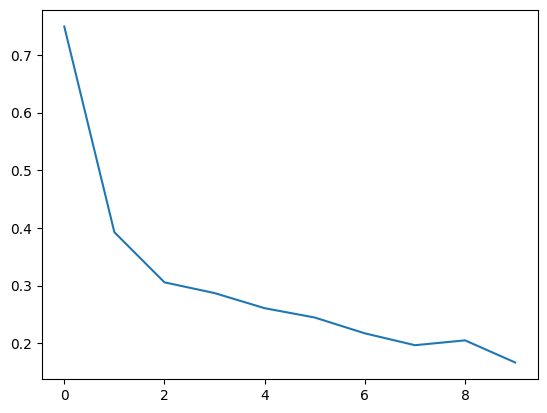

In [103]:
import matplotlib.pyplot as plt
plt.plot(losses)

Predicted class: Sunflower (confidence: 1.00)
Lilly: 0.00
Lotus: 0.00
Orchid: 0.00
Sunflower: 1.00
Tulip: 0.00


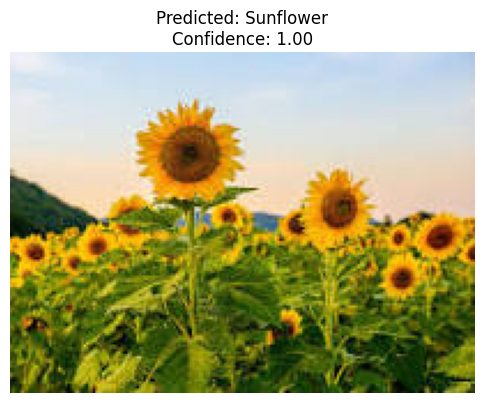

In [108]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Use the trained dense_net model
dense_net.to(device)
dense_net.eval()

# Load image
img_path = '/content/sunflower.jpeg'
image = Image.open(img_path).convert('RGB')



input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    outputs = dense_net(input_tensor)
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    _, predicted = torch.max(outputs, 1)

class_names = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
predicted_class = class_names[predicted.item()]
confidence = probabilities[predicted.item()].item()

torch.manual_seed(40)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Predicted class: {predicted_class} (confidence: {confidence:.2f})")

# Optional: Print all probabilities
for i, prob in enumerate(probabilities):
    print(f"{class_names[i]}: {prob:.2f}")

# Plot the image with predicted label
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
plt.show()


Predicted class: Lotus (confidence: 0.79)
Lilly: 0.16
Lotus: 0.79
Orchid: 0.04
Sunflower: 0.01
Tulip: 0.01


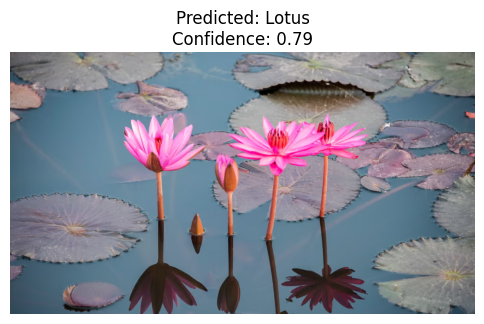

In [111]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the trained dense_net model
dense_net.to(device)
dense_net.eval()

# Load image
img_path = '/content/lotus.avif'
image = Image.open(img_path).convert('RGB')

# Define transform if not defined yet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    outputs = dense_net(input_tensor)
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    _, predicted = torch.max(outputs, 1)

class_names = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']
predicted_class = class_names[predicted.item()]
confidence = probabilities[predicted.item()].item()

torch.manual_seed(40)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Predicted class: {predicted_class} (confidence: {confidence:.2f})")

# Optional: Print all probabilities
for i, prob in enumerate(probabilities):
    print(f"{class_names[i]}: {prob:.2f}")

# Plot the image with predicted label
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
plt.show()
